<a href="https://colab.research.google.com/github/harsha-bsm/Deeplearning-/blob/main/Sample_MT_using_Encoder_Decoder_ArchitectureV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Encoder Decoder Architecture

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

--2020-12-14 13:21:26--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.24.109.196, 104.24.108.196, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7521114 (7.2M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.17M  18.9MB/s    in 0.4s    

2020-12-14 13:21:27 (18.9 MB/s) - ‘ita-eng.zip’ saved [7521114/7521114]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [3]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2020-12-14 13:21:34--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2020-12-14 13:21:35--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc34a44b976691c57df8436ef9b3.dl.dropboxusercontent.com/cd/0/inline/BFCsiRvKZey4a1TPzamT1AHuhzwDES7FxOOyZ67j4JerjsrRJyWuNwbujo8ogU2wwpLspgWY08f-SD3cgOCf1pXZ2VtrBrWypKta12vfzB2CE4jVFn6hIuACwmArtdGzfFE/file# [following]
--2020-12-14 13:21:35--  https://uc34a44b976691c57df8436ef9b3.dl.dropboxusercontent.com/cd/0/inline/BFCsiRvKZey4a1TPzamT1AHuhzwDES7FxOOyZ67j4JerjsrRJyWuNwbujo8ogU2wwpLspgWY08f-SD3cgOCf1pXZ2VtrBrWy

### <font color='blue'>**Loading data**</font>

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,Concatenate,TimeDistributed,Masking,GRU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np

In [5]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(343813, 2)


,english,italian
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


In [6]:
def decontractions(phrase):
    # ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):

    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):

    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,run,corri
2,run,corra
3,run,correte
4,who,chi


In [7]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

In [8]:
for i in range(0,101,10):
    print(i,np.percentile(ita_lengths, i))
for i in range(90,101):
    print(i,np.percentile(ita_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_lengths, i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 92.0
99.1 12.0
99.2 12.0
99.3 13.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 20.0
100 92.0


In [9]:
for i in range(0,101,10):
    print(i,np.percentile(eng_lengths, i))
for i in range(90,101):
    print(i,np.percentile(eng_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

0 1.0
10 4.0
20 4.0
30 5.0
40 5.0
50 6.0
60 6.0
70 7.0
80 7.0
90 8.0
100 101.0
90 8.0
91 9.0
92 9.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 101.0
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 21.18800000002375
100 101.0


> <font color="blue"><b>If you observe the values, 99.9% of the data points are having length &lt; 20, so select the sentences that have words &lt; 20 </b> </font>
<br>
<br>
> <font color="green"><b>Inorder to do the teacher forcing while training of seq-seq models, lets create two new columns, one with  &lt;start&gt; token at begining of the sentence and other column with &lt;end&gt; token at the end of the sequence</b></font>

In [10]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,corri,<start> run,run <end>
2,corra,<start> run,run <end>
3,correte,<start> run,run <end>
4,chi,<start> who,who <end>


In [11]:
data.sample(10)

,italian,english_inp,english_out
233431,farebbe meglio a non uscire oggi,<start> you would better not go out today,you would better not go out today <end>
293103,sei preoccupato per il riscaldamento globale,<start> are you worried about global warming,are you worried about global warming <end>
328706,la germania era alleata con litalia durante la...,<start> germany was allied with italy in world...,germany was allied with italy in world war ii ...
36518,non mi è mai piaciuto,<start> i never liked it,i never liked it <end>
110841,che aspetto aveva,<start> what did he look like,what did he look like <end>
324268,dipinse il quadro che è sul muro,<start> he painted the picture which is on the...,he painted the picture which is on the wall <end>
264281,ci sono molti problemi da risolvere,<start> there are many problems to solve,there are many problems to solve <end>
174772,è sicura che sia tutto finito,<start> are you sure it is all over,are you sure it is all over <end>
300370,la sua amica la aspettò dal cancello,<start> her friend waited for her by the gate,her friend waited for her by the gate <end>
32362,è fastidiosa,<start> you are annoying,you are annoying <end>


In [12]:
data.shape

(343388, 3)

### Getting train and test 

In [13]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [14]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(274710, 3) (68678, 3)


In [15]:
train.head()

,italian,english_inp,english_out
121082,dimostra che mi ami,<start> prove that you love me <end>,prove that you love me <end> <end>
189176,perché non cercate di rilassarvi,<start> why do not you try to relax,why do not you try to relax <end>
64472,tom ha litigato con me,<start> tom argued with me,tom argued with me <end>
96991,tu ti fideresti di loro,<start> would you trust them,would you trust them <end>
93564,tom deve andare a letto,<start> tom has to go to bed,tom has to go to bed <end>


In [16]:
validation.head()

,italian,english_inp,english_out
68542,non hai scelta,<start> you have no choice,you have no choice <end>
80462,tom lavora a tempo pieno,<start> tom works fulltime,tom works fulltime <end>
104793,mi siete mancate molto,<start> i have missed you a lot,i have missed you a lot <end>
237636,non ho mai detto che non ti volevo,<start> i never said i did not want you,i never said i did not want you <end>
34357,dammi quella chiave,<start> give me that key,give me that key <end>


In [17]:

import seaborn as sns

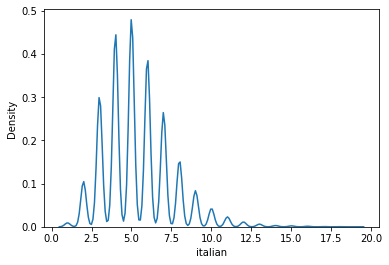

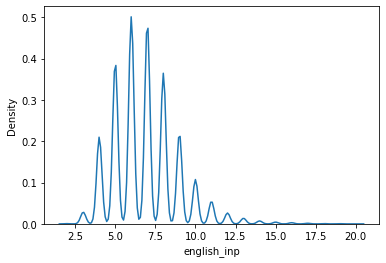

In [18]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

### Creating Tokenizer on the train data and learning vocabulary

> Note that we are fitting the tokenizer only on train data and check the filters for english, we need to remove symbols &lt; and &gt;

In [19]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [46]:
len(tknizer_eng.word_index.keys())

12829

In [47]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

12829
26201


In [48]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10147)

In [49]:
data.shape

(343388, 3)

### Creating embeddings for english sentences

In [50]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [51]:
init=tf.keras.initializers.HeNormal(
    seed=None
)

## submodels

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.inp_vocab_size=inp_vocab_size
        self.embedding_size=embedding_size
        self.lstm_size=lstm_size
        self.input_length=input_length
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.inp_vocab_size, output_dim=self.embedding_size, input_length=self.input_length, name="embedding_layer_encoder",embeddings_initializer=init)
        self.masking=Masking(mask_value=0)
        self.lstm = LSTM(self.lstm_size, return_state=True, name="Encoder_LSTM",kernel_initializer=init,dropout=0.2)
    def call(self,input_sequence,training=True):
        input_embedd = self.embedding(input_sequence)
        input_embedd=self.masking(input_embedd)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c
        
    def get_states(self):
        return self.lstm_state_h,self.lstm_state_c

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.out_vocab_size=out_vocab_size
        self.embedding_size=embedding_size
        self.lstm_size=lstm_size
        self.input_length=input_length
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.out_vocab_size, output_dim=self.embedding_size, input_length=None,
                           name="embedding_layer_decoder",weights=[embedding_matrix], trainable=False)
        self.masking=Masking(mask_value=0)
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Decoder_LSTM",kernel_initializer=init,dropout=0.2)
    def call(self,target_sentances,state_h,state_c):
        #print("DECODER ==> IN PUT SQUENCES SHAPE :",target_sentances.shape)
        target_embedd           = self.embedding(target_sentances)
        target_embedd=self.masking(target_embedd)
        #print("WE ARE INITIALIZING DECODER WITH ENCODER STATES :",state_h.shape, state_c.shape)
        lstm_output,dec_h,dec_c       = self.lstm(target_embedd, initial_state=[state_h, state_c])
        return lstm_output,dec_h,dec_c

In [ ]:
class Encoder_decoder(tf.keras.Model):
    def __init__(self,encoder_input_length,decoder_input_length,output_vocabsize):
        super().__init__()
        self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1,embedding_size=100,input_length=encoder_input_length, lstm_size=256)
        self.decoder = Decoder(out_vocab_size=vocab_size_eng+1, embedding_size=100, input_length=decoder_input_length, lstm_size=256)
        self.dense   = TimeDistributed(Dense(units=output_vocabsize+1,activation="softmax",kernel_initializer=init)) 
    def call(self, data):
        input,output = data[0], data[1]
        #print("="*20, "ENCODER", "="*20)
        encoder_output, encoder_h, encoder_c = self.encoder(input)
        decoder_output                       = self.decoder(output, encoder_h, encoder_c)[0]
        output                               = self.dense(decoder_output)
        return output    

## Data Loaders

In [65]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])
        

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [66]:
train_dataset = Dataset(data, tknizer_ita, tknizer_eng, 20)
print(train_dataset)

test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
print(train_dataloader)
test_dataloader = Dataloder(test_dataset, batch_size=1024)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
for i in train_dataloader:
  break

In [ ]:
i[0][0]

array([[4346,    0,    0, ...,    0,    0,    0],
       [7750,    0,    0, ...,    0,    0,    0],
       [7917,    0,    0, ...,    0,    0,    0],
       ...,
       [1324,    1,    0, ...,    0,    0,    0],
       [7379,    5,    1, ...,    0,    0,    0],
       [4103,    5,    1, ...,    0,    0,    0]], dtype=int32)

### Callbacks


In [ ]:
#earlystopping
import numpy as np


class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=3):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        #self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get("loss")
        current_valloss = logs.get("val_loss")
        if np.less(current_valloss,current_loss):
            #self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))




In [ ]:

loss_object = tf.keras.losses.SparseCategoricalCrossentropy( reduction='none')

def custom_lossfunction(targets,logits):
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  loss_ = loss_object(targets, logits)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
  # Custom loss function that will not consider the loss for padded zeros.
  # Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function


In [ ]:
model  = Encoder_decoder(encoder_input_length=20,decoder_input_length=None,output_vocabsize=vocab_size_eng)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss=custom_lossfunction)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
history=model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=50, validation_data=train_dataloader, validation_steps=valid_steps,verbose=1)
model.summary()

Epoch 1/50
268/268 [==============================] - 74s 277ms/step - loss: 0.6439 - val_loss: 0.2448
Epoch 2/50
268/268 [==============================] - 73s 271ms/step - loss: 0.5680 - val_loss: 0.2229
Epoch 3/50
268/268 [==============================] - 72s 270ms/step - loss: 0.5402 - val_loss: 0.2209
Epoch 4/50
268/268 [==============================] - 73s 271ms/step - loss: 0.5078 - val_loss: 0.2064
Epoch 5/50
268/268 [==============================] - 73s 272ms/step - loss: 0.4866 - val_loss: 0.1987
Epoch 6/50
268/268 [==============================] - 73s 272ms/step - loss: 0.4456 - val_loss: 0.1844
Epoch 7/50
268/268 [==============================] - 73s 271ms/step - loss: 0.4463 - val_loss: 0.1738
Epoch 8/50
268/268 [==============================] - 73s 272ms/step - loss: 0.4097 - val_loss: 0.1597
Epoch 9/50
268/268 [==============================] - 73s 272ms/step - loss: 0.3822 - val_loss: 0.1494
Epoch 10/50
268/268 [==============================] - 73s 271ms/step - l

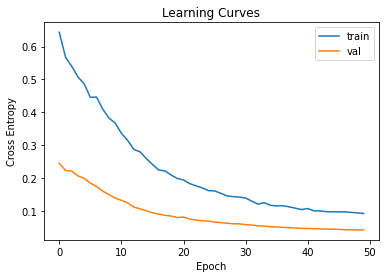

In [ ]:
import matplotlib.pyplot as plt
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()


In [ ]:
"""
import matplotlib.pyplot as plt
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
"""

"\nimport matplotlib.pyplot as plt\nplt.title('Learning Curves')\nplt.xlabel('Epoch')\nplt.ylabel('Cross Entropy')\nplt.plot(history.history['loss'], label='train')\nplt.plot(history.history['val_loss'], label='val')\nplt.legend()\nplt.show()\n"

In [ ]:

def predic_fun(input_sentence):
    input_pred=[tknizer_ita.word_index[i] for i in input_sentence.split()] 
    print("input tokens",input_pred)
    a,b,c=model.layers[0](np.expand_dims(input_pred, 0))
    state_values=[b,c]
    start="<start>"
    pred=[]
    for i in range(0,20):
        start=tknizer_eng.word_index[start] 
        cur_vec = np.array(start).reshape(1,1)
        cur_emb=model.layers[1].embedding(cur_vec)
        infe_output, state_h, state_c = model.layers[1].lstm(cur_emb, initial_state=state_values)
        state_values=[state_h, state_c]
        infe_output=model.layers[2](infe_output)
        ind=np.argmax(infe_output)
        start=tknizer_eng.index_word[ind]
        print("new eng word",start)
        pred.append(tknizer_eng.index_word[ind])
        if start=="<end>":
            break
    return pred

In [ ]:
model.layers

In [ ]:
predic_fun("dovete imparare a sopportare questo tempo")

input tokens [261, 364, 5, 1370, 24, 106]
new eng word you
new eng word need
new eng word to
new eng word keep
new eng word up
new eng word with
new eng word a
new eng word <end>


['you', 'need', 'to', 'keep', 'up', 'with', 'a', '<end>']

In [ ]:
model.save_weights('modelenc_50epoch.h5')

#ATTENTION

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,Concatenate,TimeDistributed,Masking,GRU,Dot
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.math import reduce_sum
from tensorflow.keras.backend import sum
from tensorflow.nn import softmax
from keras.callbacks import Callback

import numpy as np

In [53]:
tf.keras.backend.clear_session()

In [54]:
init=tf.keras.initializers.HeNormal(
    seed=None
)

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [55]:
class Encoder(tf.keras.Model):
    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length_enc):
        super().__init__()
        self.inp_vocab_size=inp_vocab_size
        self.embedding_size=embedding_size
        self.lstm_size=lstm_size
        self.input_length_enc=input_length_enc
        #self.lstm_output = 0
        #self.lstm_state_h=0
        #self.lstm_state_c=0
        self.embedding = Embedding(input_dim=self.inp_vocab_size, output_dim=self.embedding_size, input_length=self.input_length_enc, name="embedding_layer_encoder",embeddings_initializer=init)
        self.masking=Masking(mask_value=0)
        self.lstm = LSTM(self.lstm_size, return_sequences=True,return_state=True, name="Encoder_LSTM")
    #def build(self, input_shape):
        
        #self.masking=Masking(mask_value=0)
        
    def call(self,input_sequence,training=True):
        input_embedd = self.embedding(input_sequence)
        input_embedd=self.masking(input_embedd)
        lstm_output, lstm_state_h, lstm_state_c = self.lstm(input_embedd)
        
        return lstm_output, lstm_state_h, lstm_state_c
    
    def initialize_states(self,batch_size):
        return  [tf.zeros((batch_size,self.lstm_size)),tf.zeros((batch_size,self.lstm_size))]
    
    #def get_states(self):
        #return self.lstm_state_h,self.lstm_state_c
         
        
    
   

<font color='blue'>**Attention**</font>

In [56]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()
    self.soft = tf.keras.layers.Softmax(axis=1)
    self.scoring_function=scoring_function


    # Please go through the reference notebook and research paper to complete the scoring functions

    if self.scoring_function=='dot':
        self.dot=tf.keras.layers.Dot(axes=(-1,-1))
        # Intialize variables needed for Dot score function here
    if self.scoring_function == 'general':
        self.W1 = tf.keras.layers.Dense(att_units)
        self.dot=tf.keras.layers.Dot(axes=(-1,-1))
      # Intialize variables needed for General score function here
      
    elif self.scoring_function == 'concat':
        self.W1 = tf.keras.layers.Dense(att_units)
        self.V = tf.keras.layers.Dense(1)
      # Intialize variables needed for Concat score function here
      
  
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    
    if self.scoring_function == 'dot':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        scores=self.dot([ encoder_output,decoder_hidden_state])
        scores=self.soft(scores)
        con_vec=encoder_output*scores
        con_vec=tf.math.reduce_sum(con_vec,axis=1)
        # Implement Dot score function here
        
    elif self.scoring_function == 'general':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        scores=self.W1(decoder_hidden_state)
        scores=self.dot([ encoder_output,scores])
        scores=self.soft(scores)
        con_vec=encoder_output*scores
        con_vec=tf.math.reduce_sum(con_vec,axis=1)
        # Implement General score function here
        
    elif self.scoring_function == 'concat':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        scores=decoder_hidden_state+encoder_output
        scores=self.W1(scores)
        scores=self.V(tf.nn.tanh(scores))
        scores=self.soft(scores)
        con_vec=encoder_output*scores
        con_vec=tf.math.reduce_sum(con_vec,axis=1)\

        # Implement General score function here
        
    return con_vec,scores
    
    

<font color='blue'>**OneStepDecoder**</font>

In [57]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
    super().__init__()
    self.tar_vocab_size=tar_vocab_size
    self.embedding_dim=embedding_dim
    self.input_length=input_length
    self.dec_units=dec_units
    self.score_fun=score_fun
    self.att_units=att_units
    self.embedding = Embedding(input_dim=self.tar_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,embeddings_initializer=init,weights=[embedding_matrix], trainable=False)
    self.lstm = LSTM(self.dec_units, return_state=True, return_sequences=True,kernel_initializer=init,dropout=0.2)
    self.masking=Masking(mask_value=0)
    self.Attention=Attention(self.score_fun, self.att_units)
    self.d1 = tf.keras.layers.Dense(self.tar_vocab_size)

      # Initialize decoder embedding layer, LSTM and any other objects needed


  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    
    output=self.embedding(input_to_decoder)
    output=self.masking(output)
    con_vec,scores=self.Attention(state_h,encoder_output)
    #print("output embedding--->",output.shape)
    #print("convec embedding--->",con_vec.shape)
    
    dec_input=tf.concat([tf.expand_dims(con_vec, 1), output], axis=-1)
    #print("dec_inp.shape--->",dec_input.shape)
    output,state_h,state_c=self.lstm(dec_input,[state_h,state_c])
    # output shape == (batch_size * 1, hidden_size)
    output = tf.squeeze(output, 1)
    #output = tf.reshape(output, (-1, output.shape[2]))
#tf.shape(output)[2]
    output=self.d1(output)
    '''print("outputshape--->",output.shape)
    print("state_h--->",state_h.shape)
    print("state_c--->",state_c.shape)
    print("scores--->",scores.shape)'''
    return output,state_h,state_c,scores,con_vec
    


<font color='blue'>**Decoder**</font>

In [58]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super().__init__()
      #Intialize necessary variables and create an object from the class onestepdecoder
        self.out_vocab_size=out_vocab_size 
        self.embedding_dim=embedding_dim
        self.input_length=input_length 
        self.dec_units=dec_units 
        self.score_fun=score_fun
        self.att_units=att_units
        self.OneStep_Decoder=OneStepDecoder(tar_vocab_size=self.out_vocab_size, 
                                            embedding_dim=self.embedding_dim,
                                            input_length=self.input_length, dec_units=self.dec_units 
                                            ,score_fun=self.score_fun ,att_units=self.att_units)
        

    #@tf.function
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):
        all_outputs=tf.TensorArray(tf.float32,size=20,name="output_arrays")
        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        for timestep in range(0,20):
            output,decoder_hidden_state,decoder_cell_state,_,_=self.OneStep_Decoder(input_to_decoder[:,timestep:timestep+1],encoder_output,decoder_hidden_state,decoder_cell_state)
            all_outputs=all_outputs.write(timestep,output)
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
        
        return all_outputs
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        
        
    

<font color='blue'>**Encoder Decoder model**</font>

In [59]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length_enc,out_vocab_size, embedding_dim, input_length_dec, dec_units ,score_fun ,att_units):
    super().__init__()
    self.inp_vocab_size=inp_vocab_size
    self.embedding_size=embedding_size
    self.lstm_size=lstm_size
    self.input_length_enc=input_length_enc
        #self.lstm_output = 0
    self.lstm_state_h=0
    self.lstm_state_c=0
    self.out_vocab_size=out_vocab_size
    self.embedding_dim=embedding_dim
    self.input_length_dec=input_length_dec 
    self.dec_units=dec_units 
    self.score_fun=score_fun 
    self.att_units=att_units
    self.decoder=Decoder(out_vocab_size=self.out_vocab_size+1, embedding_dim=self.embedding_dim, input_length=self.input_length_dec, 
                              dec_units=self.dec_units ,score_fun=self.score_fun ,att_units=self.att_units)
    self.encoder=Encoder(inp_vocab_size=self.inp_vocab_size+1,embedding_size=self.embedding_size,lstm_size=self.lstm_size,input_length_enc=self.input_length_enc)
    #Intialize objects from encoder decoder
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    input,output = data[0], data[1]
    #print(input.shape)
    #self.lstm_state_h,self.lstm_state_c=self.encoder.initialize_states(len(data[0]))
    lstm_output_enc, self.lstm_state_h,self.lstm_state_c=self.encoder(input,training=True)
    print(lstm_output_enc.shape)
    all_outputs=self.decoder(output,lstm_output_enc,self.lstm_state_h,self.lstm_state_c)
    #print(all_outputs.shape)
    return all_outputs

In [60]:

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',from_logits=True)

def custom_lossfunction(real,pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
  # Custom loss function that will not consider the loss for padded zeros.
  # Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function


In [61]:
#earlystopping
import numpy as np


class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
    def __init__(self, patience=3):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        #self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get("loss")
        current_valloss = logs.get("val_loss")
        if np.less(current_valloss,current_loss):
            #self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))




In [63]:
class save_modelweights(Callback):
    def on_epoch_end(self, epoch, logs=None):
      if (epoch+1)%5 == 0:
        
        self.model.save_weights("/content/"+"weights_"+str(epoch+1),save_format="h5",overwrite=False)
        print(" weights of  {} epoch are saved ".format(epoch+1))

### lstm - 256

In [67]:
modela_256  = encoder_decoder(inp_vocab_size=vocab_size_ita,embedding_size=100,lstm_size=256,input_length_enc=20,out_vocab_size=vocab_size_eng, embedding_dim=100, input_length_dec=20, dec_units=256,score_fun="dot",att_units=128)
optimizer = tf.keras.optimizers.Adam()
modela_256.compile(optimizer=optimizer,loss=custom_lossfunction)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
history_256=modela_256.fit(train_dataloader, steps_per_epoch=train_steps, epochs=50, validation_data=train_dataloader, validation_steps=valid_steps,verbose=1,callbacks=[EarlyStoppingAtMinLoss(),save_modelweights()])
modela_256.summary()

(1024, 20, 256)
Epoch 1/50
(None, None, 256)
(None, None, 256)
268/268 [==============================] - 74s 275ms/step - loss: 1.9098 - val_loss: 1.1363
Epoch 2/50
268/268 [==============================] - 68s 252ms/step - loss: 1.6834 - val_loss: 1.0259
Epoch 3/50
268/268 [==============================] - 67s 251ms/step - loss: 1.5347 - val_loss: 0.9472
Epoch 4/50
268/268 [==============================] - 67s 251ms/step - loss: 1.4911 - val_loss: 0.8770
Epoch 5/50
268/268 [==============================] - 67s 250ms/step - loss: 1.3822 - val_loss: 0.8209
Epoch 6/50
268/268 [==============================] - 67s 251ms/step - loss: 1.3131 - val_loss: 0.7757
Epoch 7/50
268/268 [==============================] - 67s 249ms/step - loss: 1.2435 - val_loss: 0.7149
Epoch 8/50
268/268 [==============================] - 67s 250ms/step - loss: 1.1662 - val_loss: 0.6697
Epoch 9/50
268/268 [==============================] - 67s 250ms/step - loss: 1.0795 - val_loss: 0.6012
Epoch 10/50
268/268 [

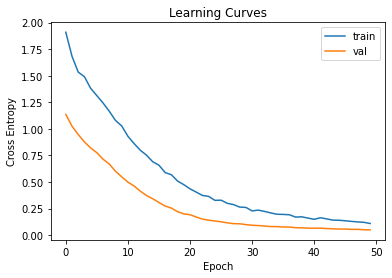

In [68]:
import matplotlib.pyplot as plt
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history_256.history['loss'], label='train')
plt.plot(history_256.history['val_loss'], label='val')
plt.legend()
plt.show()


In [130]:
def evaluate(sentence):
  attention_plot = np.zeros((20, 20))
  fi=""
  for word in sentence.split():
    if word not in tknizer_ita.word_index.keys():
      word=""
    fi=fi+word+" "
  sentence=fi
  sentence = decontractions(sentence)
  sentence=preprocess_ita(sentence)
  inputs = [tknizer_ita.word_index[i] for i in sentence.split()]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=20,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  hidden = [tf.zeros((1, 256))]
  enc_out, enc_h,enc_c = modela_256.layers[1](inputs)
  dec_h,dec_c = enc_h,enc_c
  dec_input = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)
  for t in range(20):
    predictions,dec_h,dec_c,attention_weights,con_vec = modela_256.layers[0].layers[0](dec_input, enc_out, dec_h,dec_c)
    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += tknizer_eng.index_word[predicted_id] + ' '
    if tknizer_eng.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot
    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)
  return result, sentence, attention_plot

In [126]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np

<font color='blue'>**Plot attention weights**</font>

In [127]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')
  fontdict = {'fontsize': 10}
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

In [128]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: noi siamo pronti a ritornare 
Predicted translation: we are ready to return <end> 


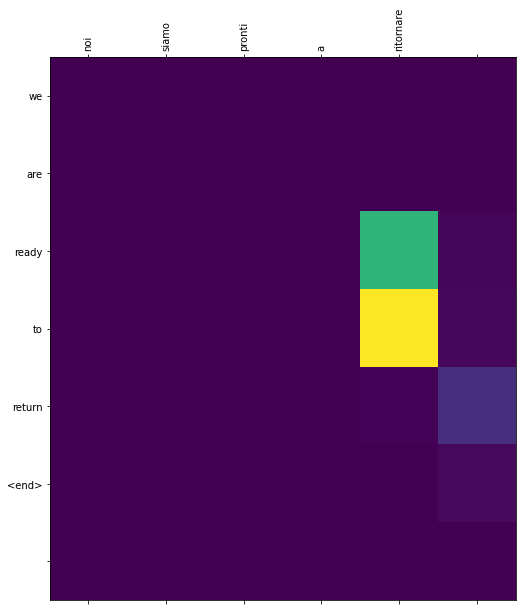

In [163]:
translate("noi siamo pronti a ritornare")

<font color='blue'>**Calculate BLEU score**</font>

In [132]:
from sklearn.utils import shuffle
import nltk.translate.bleu_score as bleu
df = shuffle(validation)[0:1000]
score=0
for (i,j) in zip(df["italian"].values,df["english_out"].apply(decontractions).apply(preprocess).values):
    blue_score=bleu.sentence_bleu(j.split(), evaluate(i)[0].split())
    score=score+blue_score
score/1000

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.2447617272710519

In [144]:
def evaluatess(sentence):
  attention_plot = np.zeros((20, 20))
  fi=""
  for word in sentence.split():
    if word not in tknizer_ita.word_index.keys():
      word=""
    fi=fi+word+" "
  sentence=fi
  sentence = decontractions(sentence)
  sentence=preprocess_ita(sentence)
  inputs = [tknizer_ita.word_index[i] for i in sentence.split()]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=20,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  hidden = [tf.zeros((1, 256))]
  enc_out, enc_h,enc_c = modela_256.layers[1](inputs)
  dec_h,dec_c = enc_h,enc_c
  dec_input = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)
  for t in range(20):
    predictions,dec_h,dec_c,attention_weights,con_vec = modela_256.layers[0].layers[0](dec_input, enc_out, dec_h,dec_c)
    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += tknizer_eng.index_word[predicted_id] + ' '
    if tknizer_eng.index_word[predicted_id] == '<end>':
      return result
    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)
  return result

In [149]:
Test["Eng_Predicted"]=pd.DataFrame(df["italian"].apply(evaluatess))

In [150]:
Test["Ennglish_actual"]=df["english_out"]

In [151]:
Test["Input_Italian"]=df["italian"]

In [161]:
Test[["Input_Italian","Eng_Predicted","Ennglish_actual"]][900:920]

,Input_Italian,Eng_Predicted,Ennglish_actual
242378,tom non ha mai avuto una ragazza,tom has never had a girlfriend <end>,tom has never had a girlfriend <end>
132092,ho dimenticato di indossare una cintura,i forgot to wear a belt <end>,i forgot to wear a belt <end>
208174,quanto tempo dovrò aspettare,how long will i have to wait <end>,how long will i have to wait <end>
94035,tom è molto estroverso,tom is very outgoing <end>,tom is very outgoing <end>
130713,lui è basso ma forte,he is short but strong <end>,he is short but strong <end>
35181,sono venuta ieri,i came yesterday <end>,i came yesterday <end>
110652,noi siamo pronti a ritornare,we are ready to return <end>,we are ready to return <end>
61621,sono molto impegnato qui,i am very busy here <end>,i am very busy here <end>
170500,tom non è più stupido di te,tom is not dumber than you <end>,tom is not dumber than you <end>
293960,ecco un elenco di quello che dobbiamo comprare,here is a list of what we need to buy <end>,here is a list of what we need to buy <end>
